# Lecture 5: How to manage your experiments in TensorFlow


### Gradient in Tensor flow
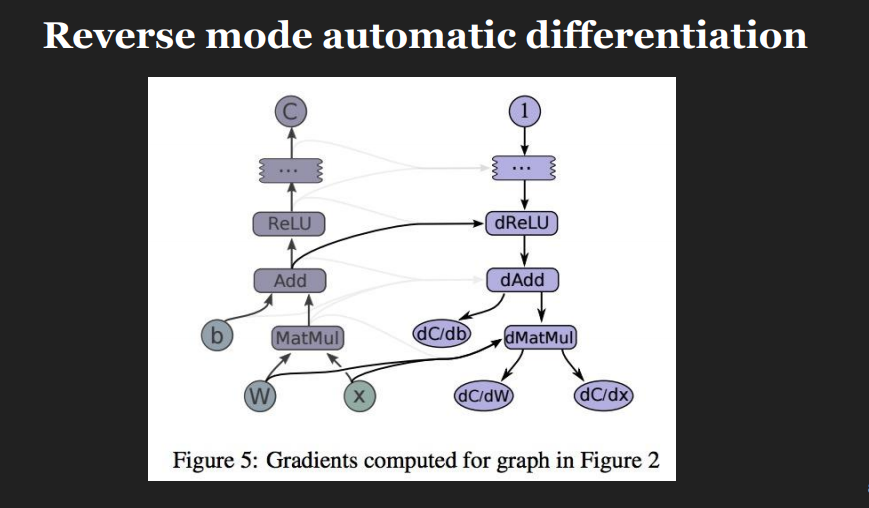

In [1]:
import tensorflow as tf
tf.reset_default_graph()
x = tf.Variable(2.0)
y = 2.0 * (x ** 3)
z = 3.0 + y ** 2
dz_dx,dz_dy = tf.gradients(z,[x,y])
init = tf.global_variables_initializer()
with tf.Session() as sess1:
    sess1.run(init)
    print sess1.run([dz_dx,dz_dy])

    
# 768 is the gradient of z with respect to x, 32 with respect to y

[768.0, 32.0]


In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'
import numpy as np
import tensorflow as tf
from tensorflow.contrib.tensorboard.plugins import projector

from process_data import process_data
import utils

In [3]:
#Variables
VOCAB_SIZE = 50000
BATCH_SIZE = 128
EMBED_SIZE = 128 # dimension of the word embedding vectors ( Size of the hidden layer)
SKIP_WINDOW = 1 # the context window
NUM_SAMPLED = 64    # Number of negative examples to sample.
LEARNING_RATE = 1.0
NUM_TRAIN_STEPS = 1000
WEIGHTS_FLD = 'processed/'
SKIP_STEP = 2000  # how many steps to skip before reporting the loss


In [4]:
# A model template
class SkipGramModel:
    """ Build the graph for word2vec model """
    def __init__(self, vocab_size, embed_size, batch_size, num_sampled, learning_rate):
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.batch_size = batch_size
        self.num_sampled = num_sampled
        self.lr = learning_rate
        self.global_step = tf.Variable(0, dtype=tf.int32, trainable=False, name='global_step')

    def _create_placeholders(self):
        """ Step 1: define the placeholders for input and output """
        with tf.name_scope("data"):
            self.center_words = tf.placeholder(tf.int32, shape=[self.batch_size], name='center_words')
            self.target_words = tf.placeholder(tf.int32, shape=[self.batch_size, 1], name='target_words')

    def _create_embedding(self):
        """ Step 2: define weights. In word2vec, it's actually the weights that we care about """
        # Assemble this part of the graph on the CPU. You can change it to GPU if you have GPU
        with tf.device('/cpu:0'):
            with tf.name_scope("embed"):
                self.embed_matrix = tf.Variable(tf.random_uniform([self.vocab_size, 
                                                                    self.embed_size], -1.0, 1.0), 
                                                                    name='embed_matrix')

    def _create_loss(self):
        """ Step 3 + 4: define the model + the loss function """
        with tf.device('/cpu:0'):
            with tf.name_scope("loss"):
                # Step 3: define the inference
                embed = tf.nn.embedding_lookup(self.embed_matrix, self.center_words, name='embed')

                # Step 4: define loss function
                # construct variables for NCE loss
                nce_weight = tf.Variable(tf.truncated_normal([self.vocab_size, self.embed_size],
                                                            stddev=1.0 / (self.embed_size ** 0.5)), 
                                                            name='nce_weight')
                nce_bias = tf.Variable(tf.zeros([VOCAB_SIZE]), name='nce_bias')

                # define loss function to be NCE loss function
                self.loss = tf.reduce_mean(tf.nn.nce_loss(weights=nce_weight, 
                                                    biases=nce_bias, 
                                                    labels=self.target_words, 
                                                    inputs=embed, 
                                                    num_sampled=self.num_sampled, 
                                                    num_classes=self.vocab_size), name='loss')
    def _create_optimizer(self):
        """ Step 5: define optimizer """
        with tf.device('/cpu:0'):
            self.optimizer = tf.train.GradientDescentOptimizer(self.lr).minimize(self.loss, 
                                                              global_step=self.global_step)

    def _create_summaries(self):
        with tf.name_scope("summaries"):
            tf.summary.scalar("loss", self.loss)
            tf.summary.histogram("histogram loss", self.loss)
            # because you have several summaries, we should merge them all
            # into one op to make it easier to manage
            self.summary_op = tf.summary.merge_all()

    def build_graph(self):
        """ Build the graph for our model """
        self._create_placeholders()
        self._create_embedding()
        self._create_loss()
        self._create_optimizer()
        self._create_summaries()

def train_model(model, batch_gen, num_train_steps, weights_fld):
    saver = tf.train.Saver() # defaults to saving all variables - in this case embed_matrix, nce_weight, nce_bias

    initial_step = 0
    utils.make_dir('checkpoints')
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        ckpt = tf.train.get_checkpoint_state(os.path.dirname('checkpoints/checkpoint'))
        # if that checkpoint exists, restore from checkpoint
        if ckpt and ckpt.model_checkpoint_path:
            saver.restore(sess, ckpt.model_checkpoint_path)

        total_loss = 0.0 # we use this to calculate late average loss in the last SKIP_STEP steps
        writer = tf.summary.FileWriter('improved_graph/lr' + str(LEARNING_RATE), sess.graph)
        initial_step = model.global_step.eval()
        for index in range(initial_step, initial_step + num_train_steps):
            centers, targets = next(batch_gen)
            feed_dict={model.center_words: centers, model.target_words: targets}
            loss_batch, _, summary = sess.run([model.loss, model.optimizer, model.summary_op], 
                                              feed_dict=feed_dict)
            writer.add_summary(summary, global_step=index)
            total_loss += loss_batch
            if (index + 1) % SKIP_STEP == 0:
                print('Average loss at step {}: {:5.1f}'.format(index, total_loss / SKIP_STEP))
                total_loss = 0.0
                saver.save(sess, 'checkpoints/skip-gram', index)

In [5]:
def main():
    model = SkipGramModel(VOCAB_SIZE, EMBED_SIZE, BATCH_SIZE, NUM_SAMPLED, LEARNING_RATE)
    model.build_graph()
    batch_gen = process_data(VOCAB_SIZE, BATCH_SIZE, SKIP_WINDOW)
    train_model(model, batch_gen, NUM_TRAIN_STEPS, WEIGHTS_FLD)

if __name__ == '__main__':
    main()

INFO:tensorflow:Summary name histogram loss is illegal; using histogram_loss instead.
Dataset ready
